In [1]:
## Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy

# Bayesian fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand

# Fitting
from scipy.optimize import minimize
from iminuit import Minuit

In [2]:
# Import my own functions developed for AppStat2020
import sys
from importlib import reload

# Load own library
sys.path.append('../') 
import AdvAppStatFunctions as aas

import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

In [3]:
SaveFig = False

# Problem 1

In [4]:
cd

/Users/sophiawilson


In [7]:
cd AdvAppStat/Exam_other

/Users/sophiawilson/AdvAppStat/Exam_other


In [9]:
data = np.loadtxt('Data/Exam_2022_Prob1.txt')

# Visualize all Columns

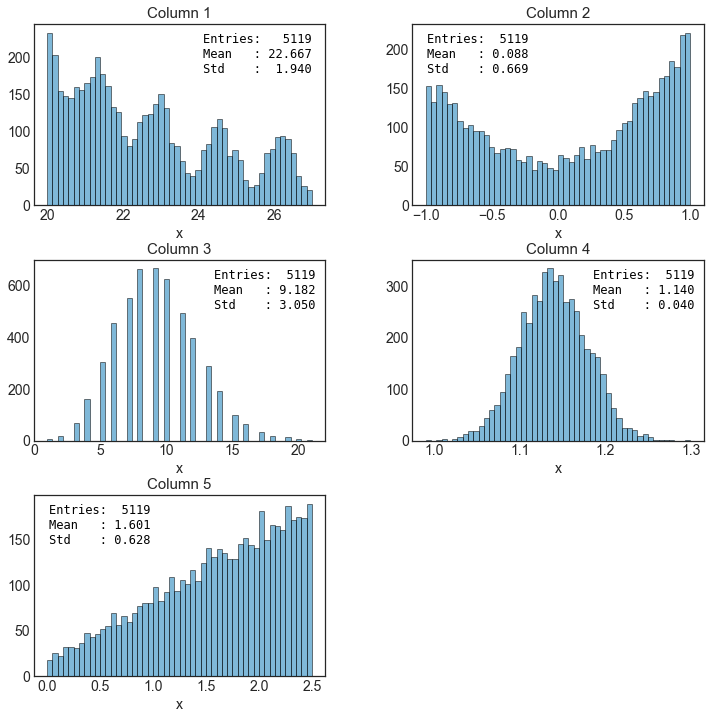

In [10]:
# Make fig
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), gridspec_kw={'wspace':0.3, 'hspace':0.3})
fig.delaxes(ax[2,1])
ax = ax.flatten()

# Define coordinates to plot
x_coords = [0.58, 0.05, 0.62, 0.62, 0.05]

# Loop over variables
for i in range(5):
    
    ax[i].hist(data[:,i], bins=50, ec='k', alpha=0.5, zorder=3)
    ax[i].set_title(f'Column {i+1}', fontsize=15)
    
    #ax[i].set_facecolor('gainsboro')
    #ax[i].grid(color='white')
    
    ax[i].set_xlabel('x')
    
    d = {r'Entries:': len(data[:,i]),
         r'Mean   :': np.mean(data[:,i]),
         r'Std    :': np.std(data[:,i], ddof=1)
         }
    text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
    aas.add_text_to_ax(x_coords[i], 0.95, text, ax[i], fontsize=12, color='k')
    
if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_1.pdf')
    
plt.show()

# First Column

We need to find the function that the data is sampled from. A list of functions is provided in the problem text.

First of all, we see the data is periodical. Furthermore it is decreasing in probability for larger values. There is also no dampening of the sine function, so it is probably this function:

$$\sin(ax)+ c e^{bx}+1$$

We used nested sampling with UltraNest, something with local minima and more robust. Since the data is periodical, there are multiple local minima, which can be difficult to fit for
minimizers. We use the example: https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html

In [10]:
# Define limits for the truncated function
xlim = (20,27)

# Define x-array
x_arr = np.linspace(*xlim, 1000)

# Define the names of the parameters
param_names = ['a', 'b', 'c']

# Define the bounds on the parameters from the slide
bounds = [(-10,10), (-10,10), (4000,8000)]

# Fitting with Nested Sampling

In [11]:
# Define pdf
# Important: func has to be as a function of the variable x and norm has to be evaluated in the x-array
def pdf(x, a, b, c):
    func = np.sin(a*x) + c * np.exp(b*x) + 1
    norm = np.trapz(np.sin(a*x_arr) + c * np.exp(b*x_arr) + 1, x_arr)
    pdf = func/norm
    return pdf

# Define the prior, we assume uniform within bounds
def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    # Copy parameters
    params = cube.copy()
    
    # Transform parameter 'a' given bounds
    lo = bounds[0][0]
    hi = bounds[0][1]
    params[0] = cube[0] * (hi - lo) + lo
    
    # Transform 'b'
    lo = bounds[1][0]
    hi = bounds[1][1]
    params[1] = cube[1] * (hi - lo) + lo
    
    # Transform 'c'
    lo = bounds[2][0]
    hi = bounds[2][1]
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

# Define likelihood
def log_likelihood(params):
    
    # Compute for each x point, where it should lie in y
    y_model = pdf(data[:,0],*params)
    
    # Compute likelihood
    llh = np.sum(np.log(y_model)) 
    return llh

In [12]:
# Initialise sampler
sampler = ultranest.ReactiveNestedSampler(param_names, log_likelihood, prior_transform)

# Seed
np.random.seed(1)

# Run it
result = sampler.run(min_num_live_points=400)
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_10333/521991732.py:42: RuntimeWarning: divide by zero encountered in log
  llh = np.sum(np.log(y_model))


[ultranest] Explored until L=-9e+03  302.01 [-9302.0426..-9302.0426]*| it/evals=8440/58077 eff=14.6332% N=400 
[ultranest] Likelihood function evaluations: 58083
[ultranest]   logZ = -9319 +- 0.1486
[ultranest] Effective samples strategy satisfied (ESS = 1717.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -9318.534 +- 0.303
  single instance: logZ = -9318.534 +- 0.195
  bootstrapped   : logZ = -9318.523 +- 0.303
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    a                   : 3.8910│ ▁▁ ▁▁▁▁▁▂▂▂▄▃▅▅▆▆▇▇▇▇▇▅▄▃▃▃▁▁▁▁▁▁▁▁▁▁ │3.9075    3.8992 +- 0.0020
    b                   : -0.3814│ ▁▁▁▁▂▂▃▅▇▇▇▇▇▆▆▆▆▅▄▅▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁ │-0.3278    -0.3596 +- 0.0085
    c         

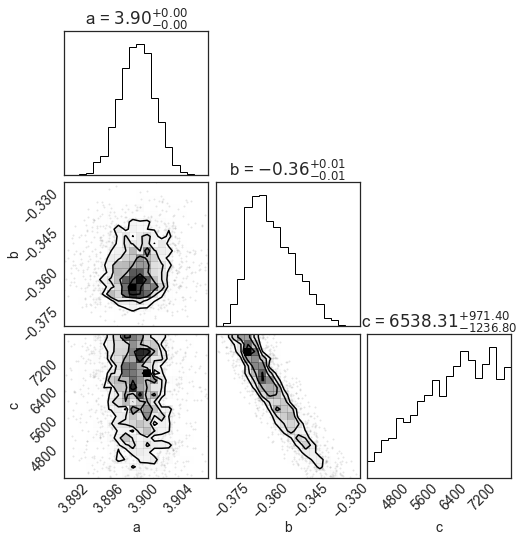

In [13]:
# Display results in cornerplot
cornerplot(result)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_2.pdf')

In [14]:
# Get results as pandas frame
df_fit1 = pd.DataFrame(data = result['samples'], columns = result['paramnames'])
df_fit1.describe()

# Extract the fit parameters
a_fit = (np.mean(df_fit1['a']), np.std(df_fit1['a']))
b_fit = (np.mean(df_fit1['b']), np.std(df_fit1['b']))
c_fit = (np.mean(df_fit1['c']), np.std(df_fit1['c']))
print(f'a is: {a_fit[0]:.4f} +/- {a_fit[1]:.4f}')
print(f'b is: {b_fit[0]:.4f} +/- {b_fit[1]:.4f}')
print(f'c is: {c_fit[0]:.4f} +/- {c_fit[1]:.4f}')

a is: 3.8992 +/- 0.0020
b is: -0.3596 +/- 0.0085
c is: 6426.0623 +/- 1002.4680


# Chi2 Test

This depends on the binning. We don't want fewer than 5 entries in each bin. We choose 50 bins. We use a critical p-value of 0.05, i.e. if the p-value is below 0.05 the hypothesis that the entries are sampled from the function.

In [15]:
reload(aas);

In [16]:
# data, pdf, params, number of bins
N_bins = 70
chi2, p, binwidth = aas.chi2_hist(data[:,0], pdf, [a_fit[0], b_fit[0], c_fit[0]], N_bins)

The Chi2 is: 58.2944 with a p-value of: 0.7670


# Plotting

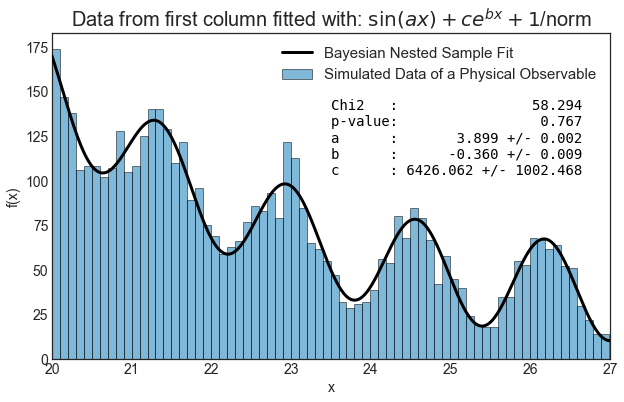

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the data
ax.hist(data[:,0], N_bins, ec='k', alpha=0.5, zorder=2, 
        label='Simulated Data of a Physical Observable')

# Plot the fit
y_arr = pdf(x_arr, a_fit[0], b_fit[0], c_fit[0]) * len(data[:,0]) * binwidth 
ax.plot(x_arr, y_arr, color='k', linewidth=3, zorder=3, label='Bayesian Nested Sample Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2   :': chi2,
     r'p-value:': p,
     r'a      :': f'{a_fit[0]:.3f} +/- {a_fit[1]:.3f}',
     r'b      :': f'{b_fit[0]:.3f} +/- {b_fit[1]:.3f}',
     r'c      :': f'{c_fit[0]:.3f} +/- {c_fit[1]:.3f}',
    }

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.50, 0.8, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data from first column fitted with: $(\sin(ax)+ce^{bx}+1$)/norm', fontsize=20)
ax.set(xlabel='x', ylabel=('f(x)'), xlim=(xlim[0], xlim[1]))

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_3.pdf')
    
plt.show()

# Second Column
Look like a parabola, we will try:

$$1+ax+bx^2$$

There is only on minimum, so we will go with a simple unbinned max likelihood minuit fit.

In [18]:
# Define limits for the truncated function
xlim = (-1,1)

# Define x-array
x_arr = np.linspace(xlim[0], xlim[1], 1000)

# Define the names of the parameters
param_names = ['a', 'b']

# Define the bounds on the parameters from the slide
bounds = [(-10,10), (-10,10)]

# Define startguesses as means of bounds
start_guess = [np.mean(bounds[0]), np.mean(bounds[1])]

In [19]:
# Define pdf
def pdf(x, a, b):
    func = 1 + a*x + b*x**2
    norm = (2/3*(b+3)) 
    pdf = func/norm
    return pdf

# Fitting with ubinned likelihood-fit

In [20]:
# Fit function using ubinned llh-fit
par, par_err, negLLH_val = aas.llh_fit(data[:,1], pdf, start_guess, param_names)

# Chi2-test

In [21]:
N_bins = 70
chi2, p, binwidth =  aas.chi2_hist(data[:,1], pdf, par, N_bins)

The Chi2 is: 56.1346 with a p-value of: 0.8474


# Plotting

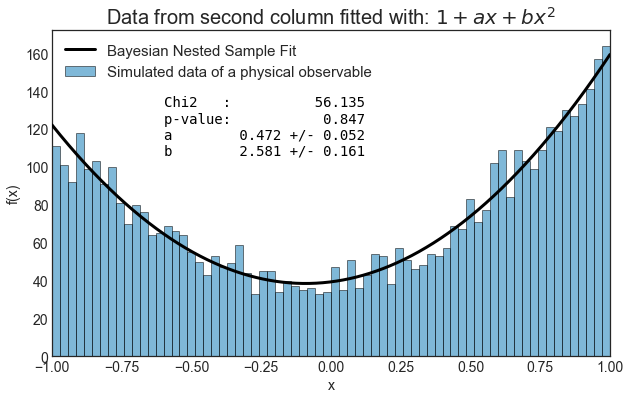

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the data
ax.hist(data[:,1], N_bins, ec='k', alpha=0.5, zorder=2, 
        label='Simulated data of a physical observable')

# Plot the fit
y_arr = pdf(x_arr, par[0], par[1]) * len(data[:,1]) * binwidth 
ax.plot(x_arr, y_arr, color='k', linewidth=3, zorder=3, label='Bayesian Nested Sample Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2   :': chi2,
     r'p-value:': p,
    }

for i in range(len(par)):
        d[f'{param_names[i]}'] = [par[i], par_err[i]]

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.20, 0.8, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data from second column fitted with: $1+ax+bx^2$', fontsize=20)
ax.set(xlabel='x', ylabel=('f(x)'), xlim=(xlim[0], xlim[1]))

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_3.pdf')
    
plt.show()

# Third Column
We notice that all entires are integers. We therefor look to the discrete functions: f(k). We can disregard the logarithmic distibution, since the most likely value of k is larger than 1 (See distributions here https://en.wikipedia.org/wiki/Logarithmic_distribution). It can thus either be poisson or binomial.

In [24]:
# The function is not truncated, but both poisson and binomial are bounded at 0. 
# The largest value is 21, so we will bound it at 30
xlim3 = (0,30)

# Define x-array
x_arr3 = np.linspace(xlim3[0],xlim3[1],xlim3[1]+1)

# Define names and start guesses for Poisson parameters
param_names_poisson = ['lambda']
start_guess_poisson = [5]

# Define names and start guesses for binomial parameters
param_names_binomial = ['n', 'p']
start_guess_binomial = [11000, 0.00084]

In [25]:
def pdf_poisson(x, lamb):
    pdf = scipy.stats.poisson.pmf(x, lamb)
    return pdf

def pdf_binomial(x, n, p):
    pdf = stats.binom.pmf(x, n, p)
    return pdf

In [26]:
par_p, par_err_p, negLLH_val_p = aas.llh_fit(data[:,2], pdf_poisson, start_guess_poisson, param_names_poisson)
par_b, par_err_b, negLLH_val_b = aas.llh_fit(data[:,2], pdf_binomial, start_guess_binomial, param_names_binomial,
                                             verbose=False)

In [27]:
reload(aas);

In [28]:
# Extract values from histogram and outline data
N_bins = xlim3[1]

print('Poisson:')
chi2_p, prob_p, binwidth_p = aas.chi2_hist_discrete(data[:,2], pdf_poisson, par_p, N_bins)

print('\nBinomial:')
chi2_b, prob_b, binwidth_b = aas.chi2_hist_discrete(data[:,2], pdf_binomial, par_b, N_bins)

Poisson:
The Chi2 is: 11.0599 with a p-value of: 0.9447

Binomial:
The Chi2 is: 11.1575 with a p-value of: 0.9184


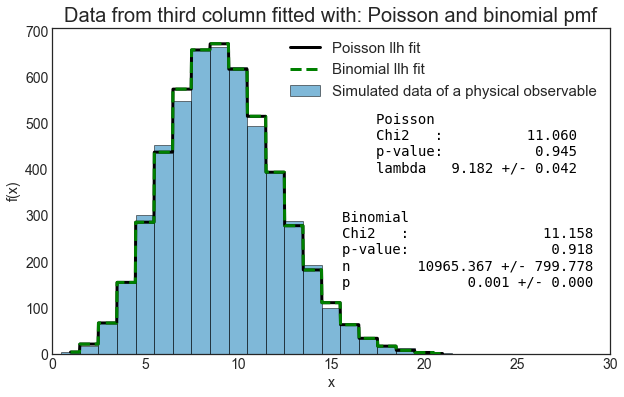

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the data
ax.hist(data[:,2], bins=np.arange(-0.5, xlim3[1],1), ec='k', alpha=0.5, zorder=2, 
        label='Simulated data of a physical observable')

# Plot Poisson fit
xarr_fit = np.linspace(min(data[:,2]), max(data[:,2]), 1000)
y_arr_fit = pdf_poisson(np.floor(xarr_fit+0.5), *par_p) * len(data[:,2]) * binwidth_p 
plt.plot(xarr_fit, y_arr_fit, color='k', linewidth=3, zorder=3, label='Poisson llh fit')

y_arr_fit = pdf_binomial(np.floor(xarr_fit+0.5), *par_b) * len(data[:,2]) * binwidth_b 
plt.plot(xarr_fit, y_arr_fit, color='g', linewidth=3, ls='dashed', zorder=3, label='Binomial llh fit')

# Put text of the fitted parameters on the plot
d = {'Poisson'  : '', 
     r'Chi2   :': chi2_p,
     r'p-value:': prob_p,
    }

for i in range(len(par_p)):
        d[f'{param_names_poisson[i]}'] = [par_p[i], par_err_p[i]]

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.58, 0.74, text, ax, fontsize=14, color='k')

# Put text of the fitted parameters on the plot
d = {'Binomial'  : '', 
     r'Chi2   :': chi2_b,
     r'p-value:': prob_b,
    }

for i in range(len(par_b)):
        d[f'{param_names_binomial[i]}'] = [par_b[i], par_err_b[i]]

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.52, 0.44, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data from third column fitted with: Poisson and binomial pmf', fontsize=20)
ax.set(xlabel='x', ylabel=('f(x)'), xlim=(xlim3[0], xlim3[1]))

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_3.pdf')
    
plt.show()